In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import numbers
import matplotlib.pyplot as plt
from publik.pyhf_modifier import modifier
from publik.pyhf_modifier import plot

In [2]:
def analysis():
    """
    Specify the likelihoods and FF parameter ranges 
    
    Returns:
        EOS analysis instance
    """

    # form factor expansion f+_0,1,2 are expansion parameters up to 2nd order
    # there is no f0_0 because of a constriant which removes one parameter

    parameters = [
        0.33772497529184886, -0.87793473613271, -0.07935870922121949, 
        0.3719622997220613, 0.07388594710238389, 0.327935912834808, 
        -0.9490004115927961, -0.23146429907794228
        ]
    paramerror = [
        0.010131234226468245, 0.09815140228051167, 0.26279803480131697, 
        0.07751034526769873, 0.14588095119443809, 0.019809720318176644, 
        0.16833757660616938, 0.36912754148836896
        ]
    sigma = 15
    analysis_args = {
        'priors': [
            { 'parameter': 'B->K::alpha^f+_0@BSZ2015', 'min': parameters[0]-sigma*paramerror[0], 'max': parameters[0]+sigma*paramerror[0], 'type': 'uniform' },
            { 'parameter': 'B->K::alpha^f+_1@BSZ2015', 'min': parameters[1]-sigma*paramerror[1], 'max': parameters[1]+sigma*paramerror[1], 'type': 'uniform' },
            { 'parameter': 'B->K::alpha^f+_2@BSZ2015', 'min': parameters[2]-sigma*paramerror[2], 'max': parameters[2]+sigma*paramerror[2], 'type': 'uniform' },
            { 'parameter': 'B->K::alpha^f0_1@BSZ2015', 'min': parameters[3]-sigma*paramerror[3], 'max': parameters[3]+sigma*paramerror[3], 'type': 'uniform' },
            { 'parameter': 'B->K::alpha^f0_2@BSZ2015', 'min': parameters[4]-sigma*paramerror[4], 'max': parameters[4]+sigma*paramerror[4], 'type': 'uniform' },
            { 'parameter': 'B->K::alpha^fT_0@BSZ2015', 'min': parameters[5]-sigma*paramerror[5], 'max': parameters[5]+sigma*paramerror[5], 'type': 'uniform' },
            { 'parameter': 'B->K::alpha^fT_1@BSZ2015', 'min': parameters[6]-sigma*paramerror[6], 'max': parameters[6]+sigma*paramerror[6], 'type': 'uniform' },
            { 'parameter': 'B->K::alpha^fT_2@BSZ2015', 'min': parameters[7]-sigma*paramerror[7], 'max': parameters[7]+sigma*paramerror[7], 'type': 'uniform' }
        ],
        'likelihood': [
            'B->K::f_0+f_++f_T@FLAG:2021A', #ONLY IN v1.0.3
            'B->K::f_0+f_++f_T@HPQCD:2022A'
        ]
    }

    analysis = eos.Analysis(**analysis_args)
    analysis.optimize()
    return analysis

## Produce samples

In [3]:
sam_ana = analysis()
# sam_cvl = 6.0
# sam_csl = 2.0
# sam_ctl = 2.0
# sam_ana.parameters['sbnunu::Re{cVL}'].set(sam_cvl)
# sam_ana.parameters['sbnunu::Re{cSL}'].set(sam_csl)
# sam_ana.parameters['sbnunu::Re{cTL}'].set(sam_ctl)

In [4]:
p = sam_ana.parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=22.90)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})
pdf = eos.SignalPDF.make('B^-->K^-nunu::dGamma/dq2', p, k, o)

null_samples, pdf_values = pdf.sample_mcmc(50000, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

/home/lorenz/publik-group/venv_publik_group/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


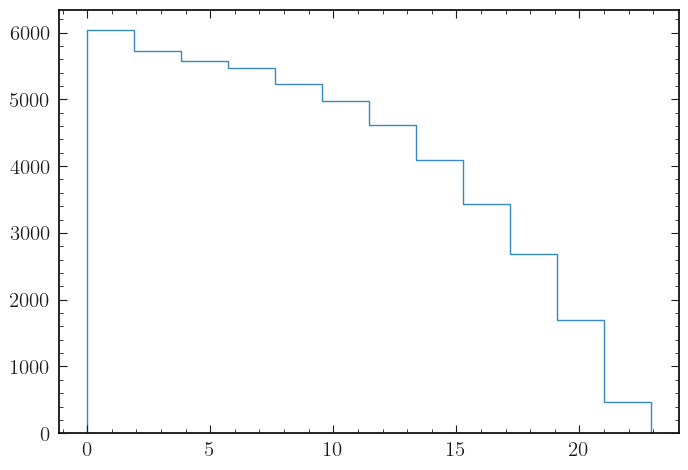

In [5]:
binning = np.linspace(0.0, 22.9, 13) 

null_yields, _, _ = plt.hist(null_samples, binning, histtype='step')

## Define null and alternative predictions

In [6]:
ana = analysis()
cvl = ana.parameters['sbnunu::Re{cVL}'         ].evaluate()
csl = ana.parameters['sbnunu::Re{cSL}'         ].evaluate()
ctl = ana.parameters['sbnunu::Re{cTL}'         ].evaluate()
fp0 = ana.parameters['B->K::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->K::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->K::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->K::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->K::alpha^f0_2@BSZ2015'].evaluate()
fT0 = ana.parameters['B->K::alpha^fT_0@BSZ2015'].evaluate()
fT1 = ana.parameters['B->K::alpha^fT_1@BSZ2015'].evaluate()
fT2 = ana.parameters['B->K::alpha^fT_2@BSZ2015'].evaluate()

In [7]:
class null:
    def __init__(self):
        self.parameters = eos.Parameters()
        self.options = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

    def distribution(self, q2):
        if isinstance(q2, numbers.Number):
            obs = eos.Observable.make(
                'B->Knunu::dBR/dq2', 
                self.parameters, 
                eos.Kinematics(q2=q2),
                self.options).evaluate()
        else:
            obs = np.array([eos.Observable.make(
                'B->Knunu::dBR/dq2', 
                self.parameters, 
                eos.Kinematics(q2=q),
                self.options).evaluate() 
                   for q in q2])
            
        return obs
    
class alt:
    def __init__(self):
        self.ana = analysis()
        self.options = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

    def distribution(self, q2, cvl, csl, ctl,  fp0, fp1, fp2, f01, f02, fT0, fT1, fT2):
        self.ana.parameters['sbnunu::Re{cVL}'         ].set(cvl)
        self.ana.parameters['sbnunu::Re{cSL}'         ].set(csl)
        self.ana.parameters['sbnunu::Re{cTL}'         ].set(ctl)
        self.ana.parameters['B->K::alpha^f+_0@BSZ2015'].set(fp0)
        self.ana.parameters['B->K::alpha^f+_1@BSZ2015'].set(fp1)
        self.ana.parameters['B->K::alpha^f+_2@BSZ2015'].set(fp2)
        self.ana.parameters['B->K::alpha^f0_1@BSZ2015'].set(f01)
        self.ana.parameters['B->K::alpha^f0_2@BSZ2015'].set(f02)
        self.ana.parameters['B->K::alpha^fT_0@BSZ2015'].set(fT0)
        self.ana.parameters['B->K::alpha^fT_1@BSZ2015'].set(fT1)
        self.ana.parameters['B->K::alpha^fT_2@BSZ2015'].set(fT2)

        if isinstance(q2, numbers.Number):
            obs = eos.Observable.make(
                'B->Knunu::dBR/dq2', 
                self.ana.parameters, 
                eos.Kinematics(q2=q2),
                self.options).evaluate()
        else:
            obs = np.array([eos.Observable.make(
                'B->Knunu::dBR/dq2', 
                self.ana.parameters, 
                eos.Kinematics(q2=q),
                self.options).evaluate() 
                   for q in q2])
            
        return obs
    
null = null()
alt = alt()

In [8]:
# get covariance matrix
pars = []
for n in range(0,5):
    rng = np.random.mtrand.RandomState(74205+n)
    p, _ = alt.ana.sample(N=5000, stride=5, pre_N=1000, preruns=5, rng=rng)
    pars += p.tolist()
pars = np.array(pars)
cov = np.cov(pars.T).tolist()
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.000109,0.000696,0.000979,0.000775,0.001303,0.000088,0.000565,0.000760
1,0.000696,0.009307,0.021609,0.005688,0.010247,0.000392,0.006202,0.014710
2,0.000979,0.021609,0.067185,0.008526,0.017058,0.000097,0.011229,0.042544
3,0.000775,0.005688,0.008526,0.006233,0.011288,0.000612,0.004714,0.006588
4,0.001303,0.010247,0.017058,0.011288,0.022037,0.000978,0.008112,0.012782
5,0.000088,0.000392,0.000097,0.000612,0.000978,0.000473,0.003446,0.005830
6,0.000565,0.006202,0.011229,0.004714,0.008112,0.003446,0.031871,0.061918
7,0.000760,0.014710,0.042544,0.006588,0.012782,0.005830,0.061918,0.144128


## Set up mapping distribution

In [9]:
mapping_dist = np.diag(null_yields)
# TODO make more realistic mapping distribution

## Set up the custom modifier

In [10]:
# TODO Why do I have to initialize csl and ctl to >0. for the fit to work properly?
new_params = {
                'cvl'   :{'inits': (6.,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.5,), 'bounds': ((0., 5.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.5,), 'bounds': ((0., 5.),), 'paramset_type': 'unconstrained'},
                'FF'    :{'inits': (fp0, fp1, fp2, f01, f02, fT0, fT1, fT2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, binning)
cmod.expanded_pyhf

{'custom': (publik.pyhf_modifier.custom_modifier.add.<locals>._builder,
  publik.pyhf_modifier.custom_modifier.add.<locals>._applier),
 'histosys': (pyhf.modifiers.histosys.histosys_builder,
  pyhf.modifiers.histosys.histosys_combined),
 'lumi': (pyhf.modifiers.lumi.lumi_builder, pyhf.modifiers.lumi.lumi_combined),
 'normfactor': (pyhf.modifiers.normfactor.normfactor_builder,
  pyhf.modifiers.normfactor.normfactor_combined),
 'normsys': (pyhf.modifiers.normsys.normsys_builder,
  pyhf.modifiers.normsys.normsys_combined),
 'shapefactor': (pyhf.modifiers.shapefactor.shapefactor_builder,
  pyhf.modifiers.shapefactor.shapefactor_combined),
 'shapesys': (pyhf.modifiers.shapesys.shapesys_builder,
  pyhf.modifiers.shapesys.shapesys_combined),
 'staterror': (pyhf.modifiers.staterror.staterror_builder,
  pyhf.modifiers.staterror.staterror_combined)}

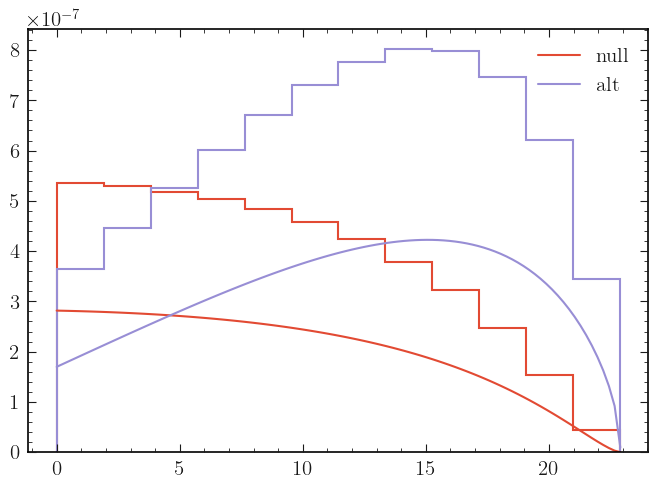

weights :  [0.68205075 0.84446179 1.01411677 1.19322938 1.38516801 1.59532707
 1.83293338 2.11522554 2.47869363 3.01679801 4.06251709 7.8291499 ]


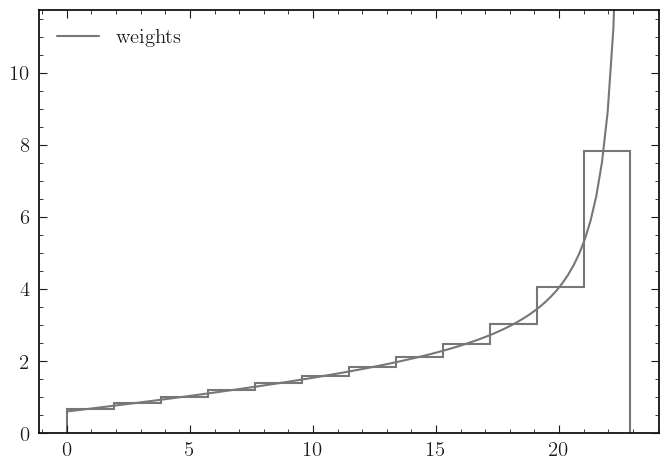

weights :  [0.68205075 0.84446179 1.01411677 1.19322938 1.38516801 1.59532707
 1.83293338 2.11522554 2.47869363 3.01679801 4.06251709 7.8291499 ]


In [11]:
cvl = 5.
csl = 3.
ctl = 2.

pars = (cvl, csl, ctl,fp0, fp1, fp2, f01, f02, fT0, fT1, fT2)
lims = [0.0, 22.9]
plot.dists(cmod, pars, lims)
plot.dists(cmod, pars, lims, plot_dists=False, plot_weights=True)

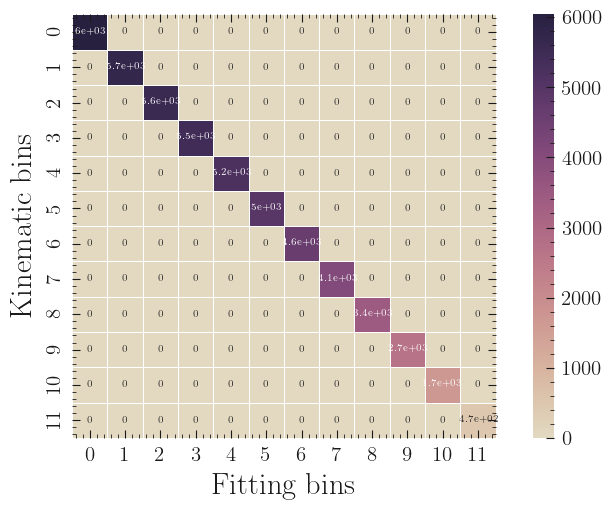

In [12]:
plot.map(cmod)

In [13]:
# Predicted yields for cvl = 5., csl = 3., ctl = 2.
alt_yields =[4119.58653784, 4836.23269317, 5653.70101686, 6522.19176571,
       7249.96934123, 7925.5848826 , 8458.98754928, 8657.61815211,
       8511.83392261, 8097.08585075, 6873.77891388, 3695.3587547 ]

In [14]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [i for i in range(len(binning)-1)],
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
data = alt_yields + model.config.auxdata
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [6040.0,
      5727.0,
      5575.0,
      5466.0,
      5234.0,
      4968.0,
      4615.0,
      4093.0,
      3434.0,
      2684.0,
      1692.0,
      472.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function',
        'ibin': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}}]}]}]}

In [15]:
model.config.par_map

{'cvl': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x7fae5c056410>},
 'csl': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x7fae5c056440>},
 'ctl': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x7fae5c056470>},
 'FF_decorrelated[0]': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fae5c0564a0>},
 'FF_decorrelated[1]': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fae5c0564d0>},
 'FF_decorrelated[2]': {'slice': slice(5, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fae5c056500>},
 'FF_decorrelated[3]': {'slice': slice(6, 7, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fae5c056530>},
 'FF_decorrelated[4]': {'slice': slice(7, 8, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at

Expected yields 
 array([4119.58653784, 4836.23269317, 5653.70101686, 6522.19176571,
       7249.96934123, 7925.5848826 , 8458.98754928, 8657.61815211,
       8511.83392261, 8097.08585075, 6873.77891388, 3695.3587547 ])


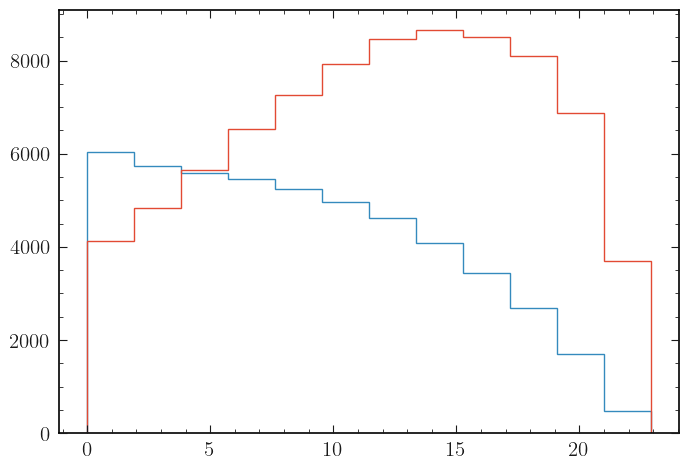

In [16]:
init = model.config.suggested_init()
init[0] = 5.
init[1] = 3.
init[2] = 2.
expected = model.expected_actualdata(init)

print('Expected yields \n', repr(expected))

plt.stairs(null_yields, binning)
plt.stairs(expected, binning)

## Perform the fit

In [17]:
fixed = model.config.suggested_fixed()
fixed[-1] = True

best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)

best_fit_dict = modifier.par_dict(model, best_fit)
print(best_fit_dict)
best_fit_dict = cmod.rotate_pars(best_fit_dict)
best_fit_dict

{'cvl': 5.000146503305089, 'csl': 2.9999149770132845, 'ctl': 2.000100152058302, 'FF_decorrelated[0]': 0.00024695377364384084, 'FF_decorrelated[1]': -0.00047005734193358964, 'FF_decorrelated[2]': -0.0013223869151699134, 'FF_decorrelated[3]': -0.0006773878535242698, 'FF_decorrelated[4]': -0.0009135793206931001, 'FF_decorrelated[5]': 0.0010636215914640707, 'FF_decorrelated[6]': 2.503117439404086e-05, 'FF_decorrelated[7]': -0.001930424967897627, 'mu': 1.0}


{'cvl': 5.000146503305089,
 'csl': 2.9999149770132845,
 'ctl': 2.000100152058302,
 'FF[0]': 0.33796785657541784,
 'FF[1]': -0.884514673387057,
 'FF[2]': -0.11074405135183303,
 'FF[3]': 0.37412574978612373,
 'FF[4]': 0.07859320520780888,
 'FF[5]': 0.3268642302728662,
 'FF[6]': -0.9625796591527654,
 'FF[7]': -0.2781519536406128,
 'mu': 1.0}

In [18]:
# TODO compute chi square between FF parameters

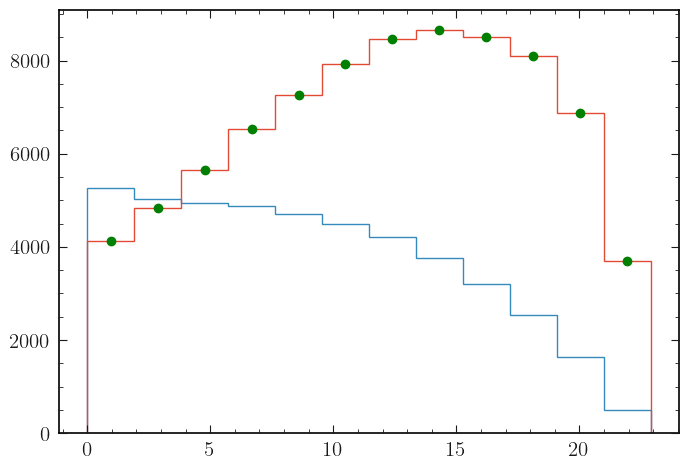

In [20]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')